In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [3]:
NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

In [4]:
threshold = 0.4
column_to_predict = "kg_CO2/kWh"

independent_variables = []


for column in train:
    if abs(train[column].corr(train[column_to_predict])) > threshold:
        independent_variables.append(column)

# independent_variables.remove(column_to_predict)
if "Index" in independent_variables:
    independent_variables.remove("Index")
independent_variables

['Hour_1',
 'Hour_2',
 'Hour_3',
 'Occupant Count (people)_3',
 '12h Outdoor Drybulb Temperature (C)',
 '24h Outdoor Drybulb Temperature (C)',
 '12h Outdoor Relative Humidity (%)',
 '6h Direct Solar Radiation (W/m2)',
 '12h Direct Solar Radiation (W/m2)',
 'kg_CO2/kWh']

In [5]:
X_train = train[independent_variables]
# X_train = train[["Hour_1", "Day Type_1"]]
Y_train = train[column_to_predict]

X_train.head()
rows, num_of_columns = X_train.shape

In [6]:
def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        #print(f"i = {i}, seq = {seq}")
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        #print(f"i = {i}, target = {target}")
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [7]:
input_sequences, target_variables = create_sequences(X_train, Y_train, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(input_sequences[0])
print(target_variables[0])
print(input_sequences.shape)
print(target_variables.shape)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  8.40305674e-01 3.41110874e-01 2.84653240e-01 1.35680787e-01
  9.03531290e-01 2.97294973e-01]
 [4.34782609e-02 4.34782609e-02 4.34782609e-02 1.00000000e+00
  8.35694132e-01 1.31464429e-01 2.36547501e-01 2.84342677e-01
  7.30342170e-01 2.06405263e-01]
 [8.69565217e-02 8.69565217e-02 8.69565217e-02 1.00000000e+00
  8.75367853e-01 1.38832035e-01 1.41625263e-01 1.86201506e-01
  8.74456687e-01 1.46160546e-01]
 [1.30434783e-01 1.30434783e-01 1.30434783e-01 1.00000000e+00
  9.60540996e-01 2.93742444e-01 1.57973161e-01 4.40658779e-01
  7.56219376e-01 1.34989510e-01]
 [1.73913043e-01 1.73913043e-01 1.73913043e-01 5.00000000e-01
  9.02450503e-01 1.80204520e-01 1.77644208e-01 5.38847476e-01
  8.33149859e-01 1.67124490e-01]
 [2.17391304e-01 2.17391304e-01 2.17391304e-01 5.00000000e-01
  8.54914265e-01 2.18826081e-01 1.59108714e-01 8.63126113e-01
  4.14593785e-01 2.18208263e-01]
 [2.60869565e-01 2.60869565e-01 2.60869565e-01 5.00000000e

In [8]:
# importing libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 5) #patience parameter to be adjusted

loss = []
val_loss = []

for train_data, test_data in tscv.split(input_sequences):
    X_train, X_test = input_sequences[train_data], input_sequences[test_data]
    y_train, y_test = target_variables[train_data], target_variables[test_data]
    
    model = keras.Sequential([
        
        # TODO I think this might be needed to group by timestamps rather than variables
        keras.layers.Permute((2,1), input_shape=(48,num_of_columns)),
        
        # include a flatten layer to convert to 1D (used as a first layer instead of reshaping)
        keras.layers.Flatten(input_shape=(num_of_columns,48)),
        # shape should be vertically, so 48 data points for x1, then x2...
        keras.layers.Dense(1200, activation='tanh'),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.Dense(600, activation='tanh'),
        keras.layers.Dense(240, activation='tanh'),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


    model.compile(
        optimizer='adam',
        loss= 'mse'
    ) #types of optimizer, loss function to be adjusted
    
    history = model.fit(X_train, y_train,
              epochs=200, 
              validation_data=(X_test, y_test),
              # validation_split = 0.8,
              verbose=1,
              #callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])

Epoch 1/200
4/4 [==============================] - 1s 53ms/step - loss: 1.6350 - val_loss: 0.2035
Epoch 2/200
4/4 [==============================] - 0s 18ms/step - loss: 0.2247 - val_loss: 0.1034
Epoch 3/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0768 - val_loss: 0.1021
Epoch 4/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0661 - val_loss: 0.0624
Epoch 5/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0353 - val_loss: 0.0392
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0350 - val_loss: 0.0362
Epoch 7/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0267 - val_loss: 0.0471
Epoch 8/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0231 - val_loss: 0.0523
Epoch 9/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0223 - val_loss: 0.0421
Epoch 10/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0191 - val_loss: 0.0361
Epoch 11/200
4/4 [=

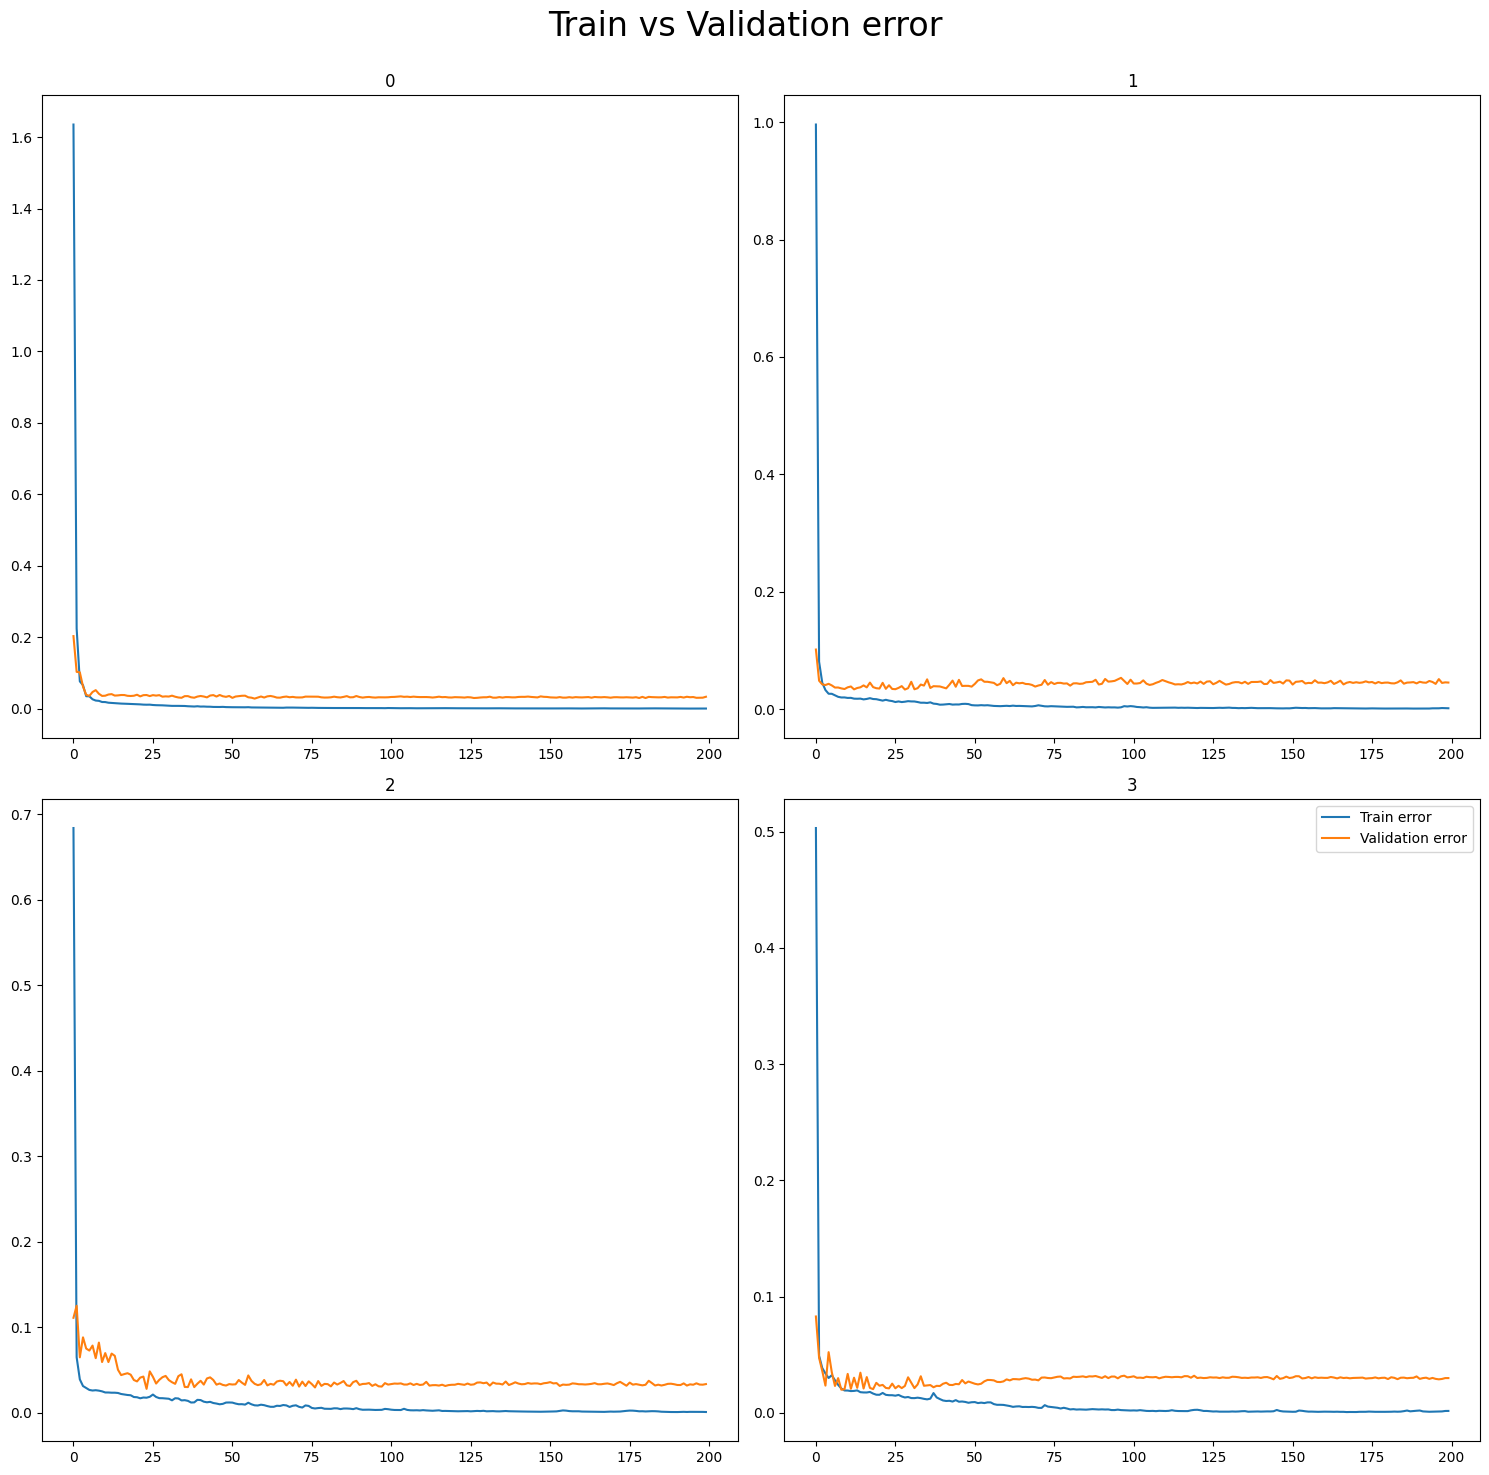

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [11]:
X_train = train[independent_variables]
Y_train = train[column_to_predict]

# Prepare data for evaluation
X_test = test[independent_variables]
# X_test = train[["Hour_1", "Day Type_1"]]
Y_test = test[column_to_predict]

# Append last 24 hours from train
last_24_X = X_train.tail(24)
last_24_Y = Y_train.tail(24)

X_test = pd.concat([last_24_X, X_test], ignore_index=True)
Y_test = pd.concat([last_24_Y, Y_test], ignore_index=True)

eval_input_sequences, eval_target_variables = create_sequences(X_test, Y_test, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(Y_test)
print(eval_input_sequences.shape)
print(eval_target_variables.shape)

0     0.353082
1     0.256588
2     0.215438
3     0.201465
4     0.186162
        ...   
91    0.587037
92    0.607686
93    0.571493
94    0.508506
95    0.414290
Name: kg_CO2/kWh, Length: 96, dtype: float64
(25, 48, 10)
(25, 24)


In [12]:
# Evaluate the model on the test data
predictions = []
#print(len(eval_target_variables))

for i in range(len(eval_target_variables)):
    current_batch = eval_input_sequences[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, num_of_columns))
    curr_pred = model.predict(current_batch)
    predictions.append(curr_pred)

1/1 [==============================] - 0s 23ms/step


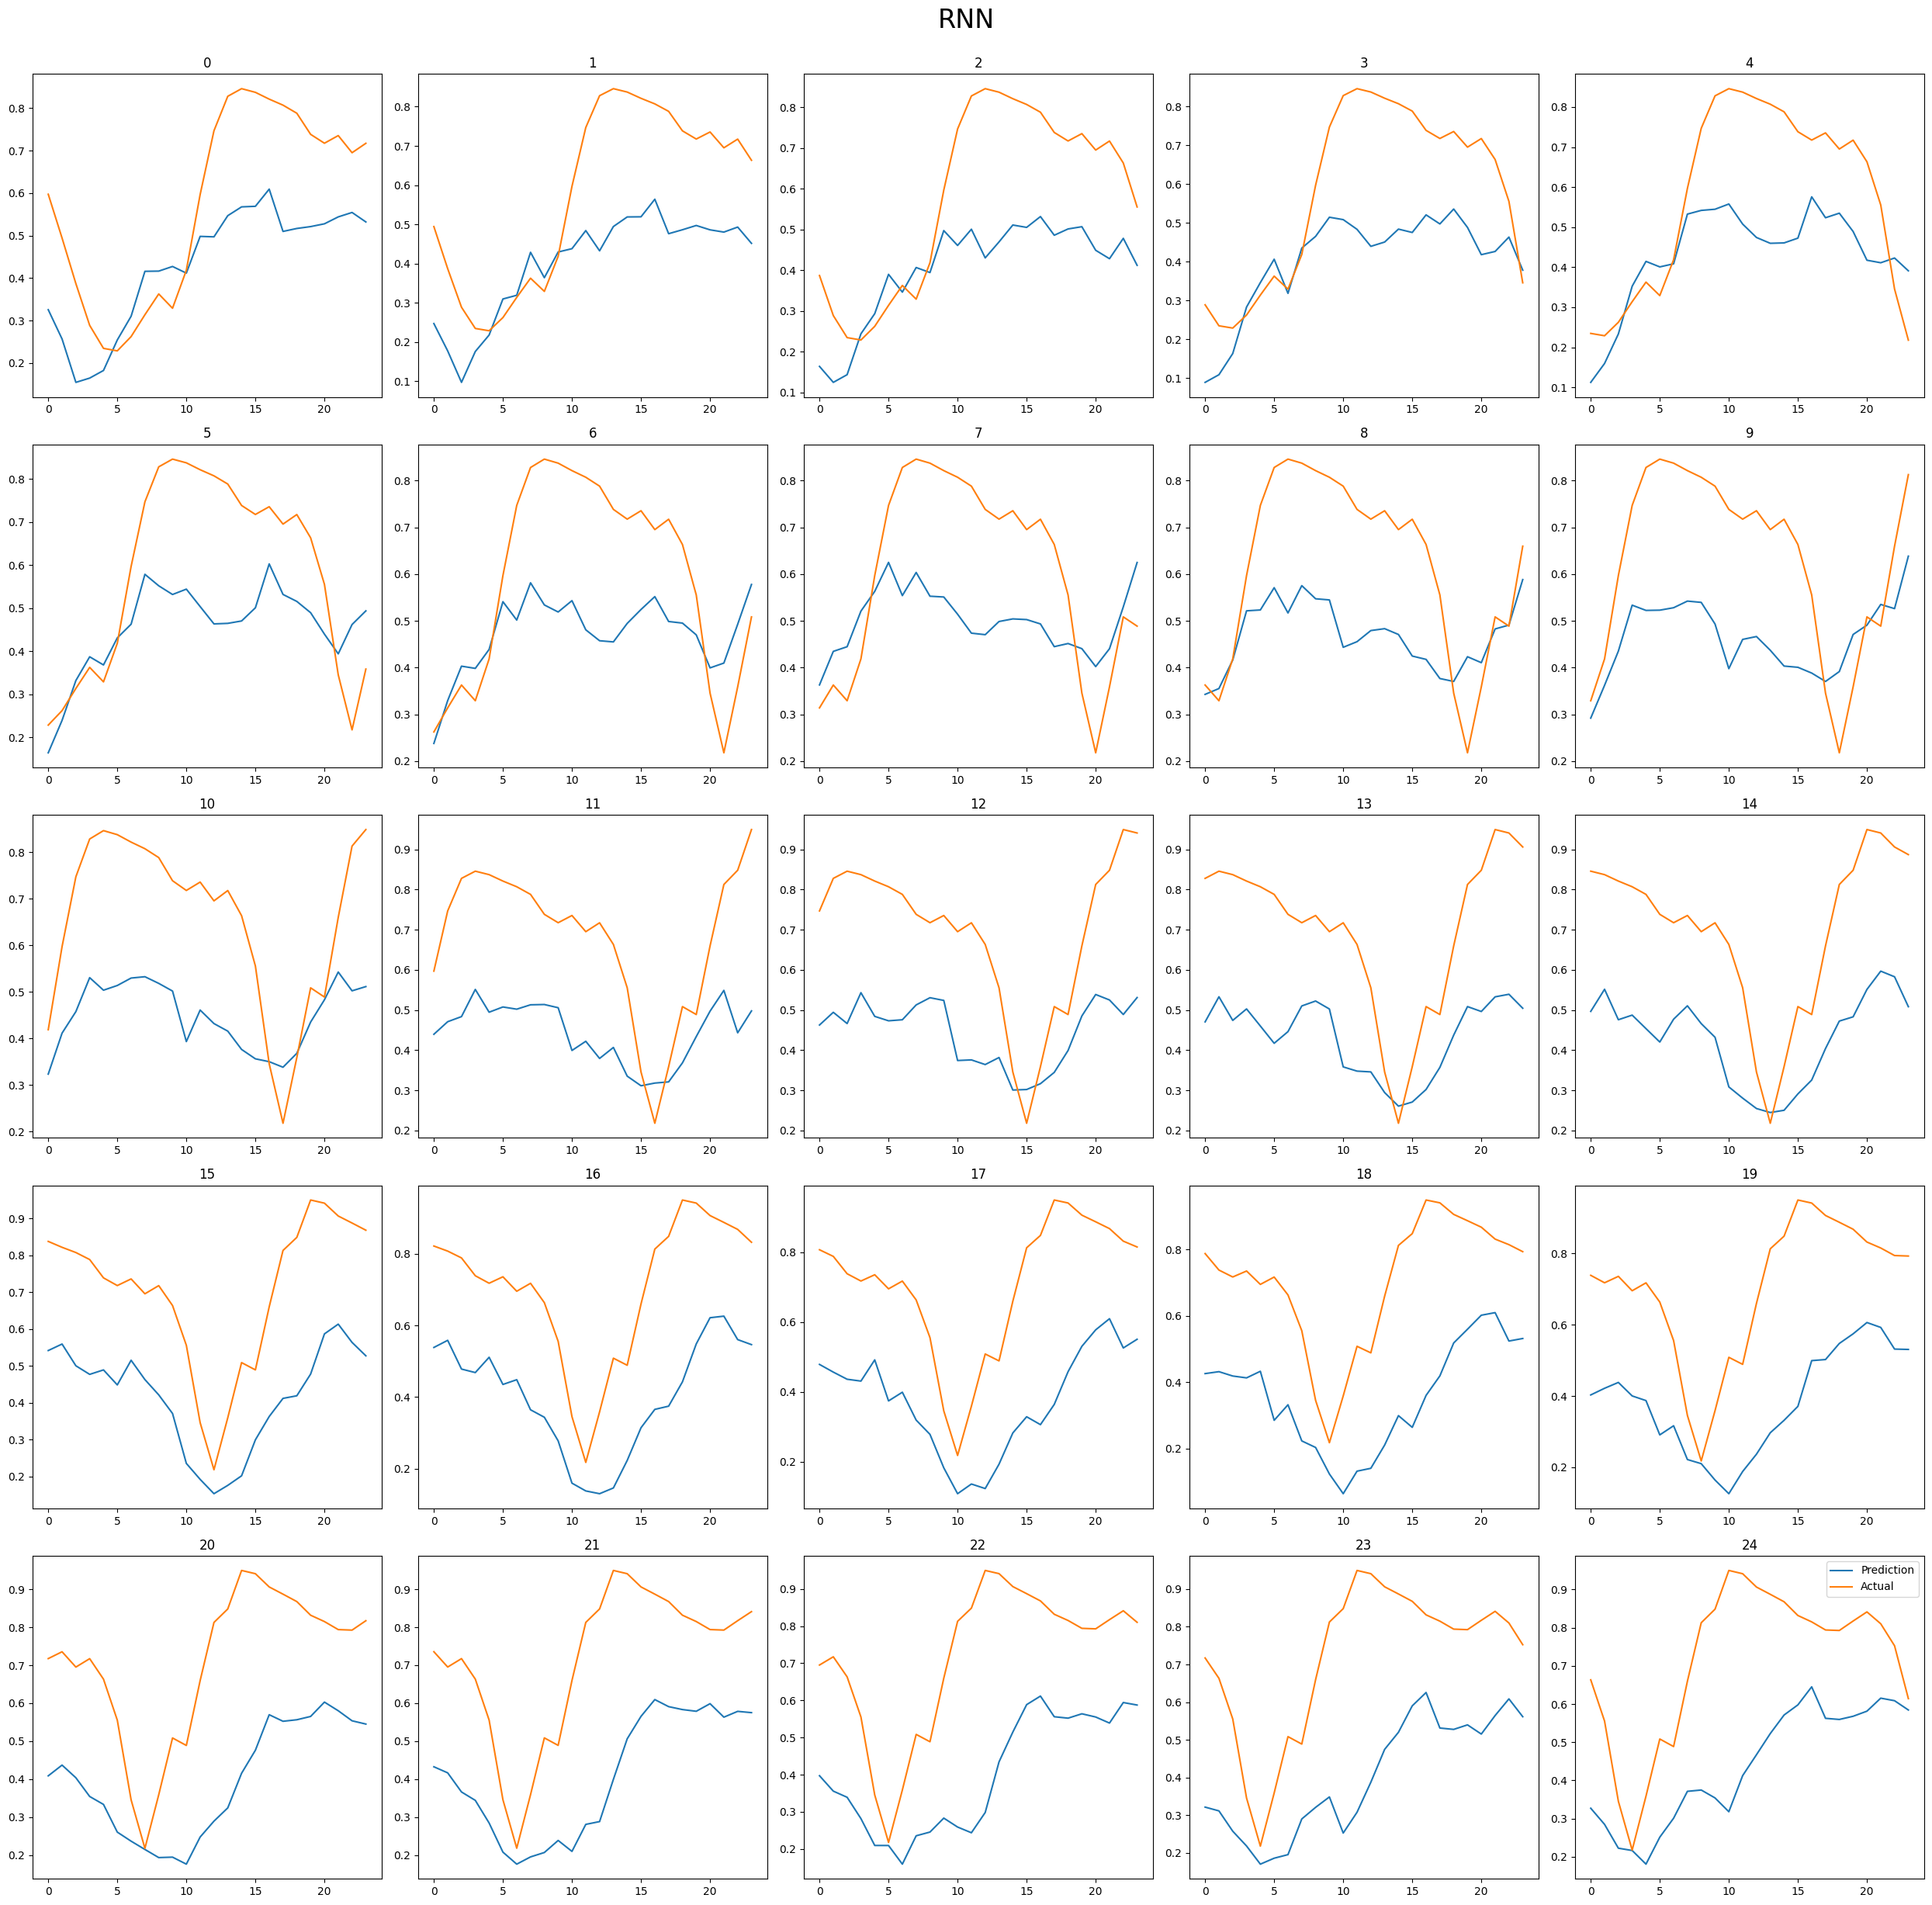

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(target_variables[i], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = 0
for i in range(len(predictions)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions[i][0], target_variables[i]))}')
    rmse += sqrt(mean_squared_error(predictions[i][0], target_variables[i]))

rmse /= len(predictions)    
print(f"RMSE = {rmse}")

pred=0, num = 0.19464148631716868
pred=1, num = 0.2228442061449674
pred=2, num = 0.2254186237297173
pred=3, num = 0.2236875957550811
pred=4, num = 0.20685698275894635
pred=5, num = 0.20050065677898377
pred=6, num = 0.20046077426357414
pred=7, num = 0.19444675686666646
pred=8, num = 0.2084067422352011
pred=9, num = 0.2251545158523506
pred=10, num = 0.24451255452385512
pred=11, num = 0.26633722363095236
pred=12, num = 0.27781251547696445
pred=13, num = 0.2912299670113023
pred=14, num = 0.28992016685873706
pred=15, num = 0.2989023680248134
pred=16, num = 0.31508703973463653
pred=17, num = 0.3469860745927047
pred=18, num = 0.3667392844093978
pred=19, num = 0.34246083968436447
pred=20, num = 0.3333486801218822
pred=21, num = 0.3271688928093603
pred=22, num = 0.3437080807375097
pred=23, num = 0.3452046507144268
pred=24, num = 0.31121030512867315
RMSE = 0.2721218793664895
